## Solving inte/diff mixed problem

The controling equation is 

$$
y'(x) = \frac{-\frac{(m-r)^2}{2\sigma^2} (y(x))^2 }{(p+rx)y(x) - \lambda \int_{0}^{x} y(t) F(x-t) dt  + \lambda F(x) \delta(0)  }
$$

in which, $F(x)$ subjects to a Benktander II distribution with parameters $(\alpha=\frac{2}{3}, \beta=\frac{2}{3})$ and is defined as

$$
F(x) = x^{-1+\beta}e^{\frac{\alpha}{\beta}-\frac{\alpha}{\beta} x^{\beta}}
$$

We generate $F(x)$ in range $[0, 300)$

In [1]:
# we setup all the parameters here
n = 300
alpha = 2.0/3.0
beta = 2.0/3.0
m = 0.05
r = 0.02
sigma = 0.1
p = 1
Lambda = 1
delta = 1.0e-10

In [2]:
import math

x = list(range(n))
def F(x):
    
    if abs(x) < 1.0e-10:
        return 1.0
    
    global alpha
    global beta
    #return x**(-1.0+beta) * math.exp(alpha/beta - alpha/(beta*(x**beta)))
    return x**(-1.0+beta) * math.exp(alpha/beta - alpha/beta*(x**beta))
                                     
Fx = list(map(F, x))

Now let's take a look at Fx series

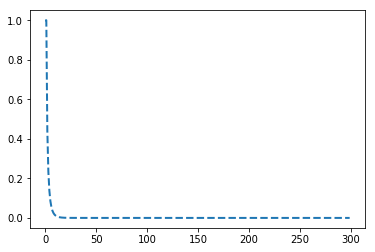

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots()
line1, = ax.plot(x, Fx, '--', linewidth=2)
plt.show()

Letting $z(x) = \int_{0}^{x} y(t) F(x-t) dt$, we approximate it with 
$$
z(n) = \frac{1}{2} \sum^{n-1}_{i=0}(y(1)F(n-i) +y(i+1)F(n-i-1))  
$$
and
$$
z(n+1) = z(n) + \int_{n}^{n+1} y(t) F(n-t) dt = z(n) + \frac{1}{2}(y(n)F(1)+y(n+1)F(0))
$$

As $F(0) = 1$ and $F(1) = 1$, we have

$$
z(n+1) = z(n) + \frac{1}{2}[y(n)+y(n+1)]
$$

or

$$
z(n) = z(n-1) + \frac{1}{2}[y(n-1)+y(n)]
$$

The controling equation is simplified to 


$$
y'(n) = \frac{-\frac{(m-r)^2}{2\sigma^2} (y(n))^2 }{(p+rn)y(n) - \lambda z(n)  + \lambda F(n) \delta(0)  }
$$



We also have an iteration function 

$$
y(n) = y(n-1) + \frac{1}{2}(y'(n-1)+y'(n))
$$

The relations between $z$, $y$ and $y'$ can be demonstrated as

![relation](./dt.png)



#### Initial values

To start with, we already have 

$$
y_0 = -\frac{p}{\lambda} \delta(0) \simeq -1.0e-10
$$

and 
$$
z_0 = 0
$$

As $y'_0$ dependends only on $y_0$ and $z_0$, we can directly calculate it

In [4]:
def cal_y_pri( y, z, n ):
    return -(m-r)**2/(2*sigma*sigma)*y*y / (p+r*n) * y - Lambda*(z-Fx[n]*delta)

And we have $y'_0$

In [5]:
cal_y_pri(-1.0e-10, 0, 0)

1e-10

As is to $y_n$, it depends on $y'_n$, $y_{n-1}$ and $y'_{n-1}$

In [6]:
# y(n) = y(n-1) + \frac{1}{2}(y'(n-1)+y'(n))
def cal_y(y_n_1, y_pri_n, y_pri_n_1):
    return y_n_1 + 0.5 * (y_pri_n + y_pri_n_1)

and $z_n$ 

In [7]:
#z(n) = z(n-1) + \frac{1}{2}[y(n-1)+y(n)]
def cal_z(z_n_1, y_n_1, y_n):
    return z_n_1 + 0.5*(y_n_1+y_n)

We first calculate numeric series $y$, $y'$ and $z$

In [8]:
import numpy as np
y = np.zeros(n)
y_ = np.zeros(n)
z = np.zeros(n)

Then assign $y_0$, $y'_0$ and $z_0$

In [9]:
y[0] = -1.0e-10
z[0] = 0
y_[0] = cal_y_pri(y[0], z[0], 0)

Thereafter, we can implement them

In [10]:
def calculate_y(n):
    return cal_y(y[n-1], y_[n], y_[n-1])
def calculate_y_(n):
    return cal_y_pri(y[n], z[n], n)
def calculate_z(n):
    return cal_z(z[n-1], y[n-1], y[n])

For the case of $n=1$, we first initialize $y[n]=y[n-1]$, $y'[n]=y'[n-1]$ and $z[n]=z[n-1]$:

In [11]:
index = 1
y[index] = y[index-1]
y_[index] = y_[index-1]
z[index] = z[index-1]

Then we start to iterate

In [12]:
for index in range( 1, n ):
    a, b, c = y[index], y_[index], z[index]
    max_iteration = 1000
    for i in range(1000):
        y[index] = calculate_y(index)
        y_[index] = calculate_y_(index)
        z[index] = calculate_z(index)
        a_, b_, c_ = a-y[index], b-y_[index], c-z[index]
        max_diff = max(abs(a_), abs(b_), abs(c_))
        if (max_diff<1.0e-5):
            break
        a, b, c = y[index], y_[index], z[index]


Now we have all the values for $y$, $y'$ and $z$

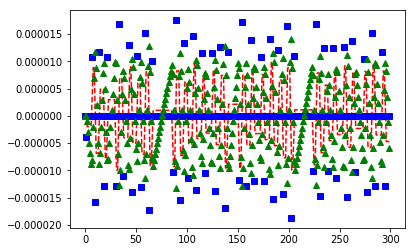

In [13]:
plt.plot(x, y, 'r--', x, y_, 'bs', x, z, 'g^')
plt.show()

And also to plot $\frac{(m-r)y(x)}{x\sigma^2y'(x)}$

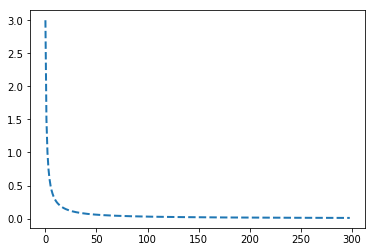

In [14]:
ratio = np.zeros(n-1)
for index in range(n-1):
    ratio[index] = (m-r)*y[index+1] /(index+1)/(sigma**2)/y[index+1]
    
fig, ax = plt.subplots()
line1, = ax.plot(range(n-1), ratio, '--', linewidth=2)
plt.show()    